<h1>Understanding the Computation for Alpha and creating a function</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
import netCDF4 as nc
import cftime
import matplotlib.animation as animation
%matplotlib widget

In [25]:
# Get Data set from mission  due to better notes on when in breaking 
mission_nc_path = '../microSWIFT_data/mission_53/mission_53.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Define Accelerations
accel_time = mission_dataset['microSWIFT_31']['IMU']['time']
accel_x = mission_dataset['microSWIFT_31']['IMU']['accel_x']
accel_y = mission_dataset['microSWIFT_31']['IMU']['accel_y']
accel_z = mission_dataset['microSWIFT_31']['IMU']['accel_z']

# Define GPS
gps_time = cftime.num2pydate(mission_dataset['microSWIFT_31']['GPS']['time'], units=mission_dataset['microSWIFT_31']['GPS']['time'].units, calendar=mission_dataset['microSWIFT_31']['GPS']['time'].calendar)
xFRF= mission_dataset['microSWIFT_31']['GPS']['x_frf']
yFRF = mission_dataset['microSWIFT_31']['GPS']['y_frf']

# Sort Data into short windows of 32 samples
samples_per_window = 32 # This value is chosen from the Brown 2018 paper
imu_sampling_freq = 12 # Units are Hz
time_per_window = samples_per_window * (1/imu_sampling_freq) # Time per each window 
num_samples = len(accel_x)
num_windows = int(num_samples/samples_per_window)
num_samples_to_use = int(num_windows * samples_per_window)

# Reshape the python array to be windowed
accel_time_windowed = accel_time[:num_samples_to_use].reshape(samples_per_window, num_windows, order='F')
accel_x_windowed = accel_x[:num_samples_to_use].reshape(samples_per_window, num_windows, order='F')
accel_y_windowed = accel_y[:num_samples_to_use].reshape(samples_per_window, num_windows, order='F')
accel_z_windowed = accel_z[:num_samples_to_use].reshape(samples_per_window, num_windows, order='F')

# Find average location of each window
xFRF_windowed = np.empty(num_windows)
yFRF_windowed = np.empty(num_windows)

for n in np.arange(num_windows):
    # Find max and min times in each window
    window_time_min = cftime.num2pydate(np.min(accel_time_windowed[:,n]), units=mission_dataset['microSWIFT_31']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_31']['IMU']['time'].calendar)
    window_time_max = cftime.num2pydate(np.max(accel_time_windowed[:,n]), units=mission_dataset['microSWIFT_31']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_31']['IMU']['time'].calendar)

    # Find GPS time indics during these times
    gps_ind_in_window = np.squeeze(np.argwhere((gps_time > window_time_min ) & (gps_time < window_time_max)))
    xFRF_windowed[n] = np.mean(xFRF[gps_ind_in_window])
    yFRF_windowed[n] = np.mean(yFRF[gps_ind_in_window])

# Compute Time of each window 
window_time = np.empty(num_windows)
for n in np.arange(num_windows):
    window_time[n] = np.mean(accel_time_windowed[:,n])

# Convert times of windows to datetime objects
window_time_datetime = cftime.num2pydate(window_time, units=mission_dataset['microSWIFT_31']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_31']['IMU']['time'].calendar)

# Set up figure properties
fig, [ax1, ax2] = plt.subplots()
ax2.set(ylim=(-25, 25))
ax2.set_xlabel('Sample Number in Window')
ax2.set_ylabel('Acceleration [m/s^2]')
accel_x_line, = ax2.plot(accel_x_windowed[:, 0], color='r', lw=2, label='X')
accel_y_line, = ax2.plot(accel_y_windowed[:, 0], color='b', lw=2, label='Y')
accel_z_line, = ax2.plot(accel_z_windowed[:, 0], color='g', lw=2, label='Z')
ax2.legend()

# def animate(n):
#    accel_x_line.set_ydata(accel_x_windowed[:, n])
#    accel_y_line.set_ydata(accel_y_windowed[:, n])
#    accel_z_line.set_ydata(accel_z_windowed[:, n])

# anim = animation.FuncAnimation(fig, animate, interval=100, frames=num_windows - 1)
# anim.save('./accel_gif.gif')
# plt.show()



[-0.189033  0.504886  0.547956 -0.239282 -0.650848 -0.267996  0.184247
 -0.11007  -0.51685   0.028714  1.079163  0.105284 -0.586242  0.167498
  0.935594  0.622134 -0.473779 -0.921237  0.619741 -0.141177]


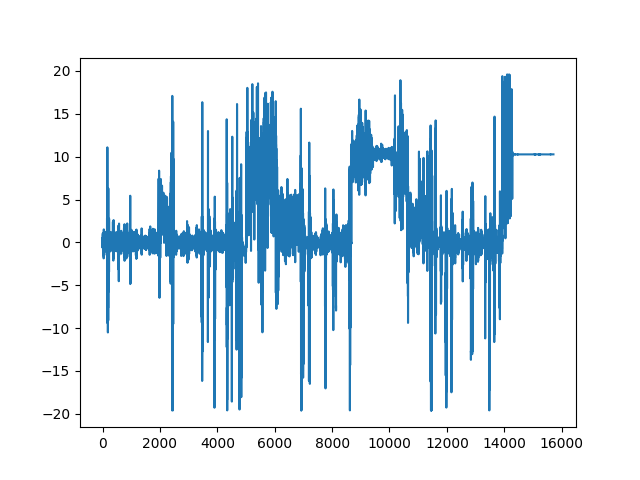

In [11]:
accel_time_datetime= cftime.num2pydate(accel_time, units=mission_dataset['microSWIFT_31']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_31']['IMU']['time'].calendar)

fig, ax = plt.subplots()
ax.plot(accel_x)
print(accel_x[:20])

In [ ]:
# For each window - compute the variance and add together to get breaker index
alpha = np.empty(num_windows)
window_time = np.empty(num_windows)
fft_freq = fft.fftshift(fft.fftfreq(samples_per_window, d=1/imu_sampling_freq))
ind_freq_greater_than_2hz = np.argwhere(fft_freq > 2)

# Compute Blackman Taper Window function
blackman_window = np.blackman(samples_per_window)

for n in np.arange(num_windows):
    # X acceleration
    accel_x_demean = accel_x_windowed[:,n] - np.mean(accel_x_windowed[:,n])
    blackman_windowed_accel_x = blackman_window * accel_x_demean
    accel_x_fft = fft.fftshift((2/samples_per_window) * np.abs(fft.fft(blackman_windowed_accel_x)))
    accel_x_fft_greater_than_2hz = np.sum(accel_x_fft[ind_freq_greater_than_2hz])

    # Y acceleration
    accel_y_demean = accel_y_windowed[:,n] - np.mean(accel_y_windowed[:,n])
    blackman_windowed_accel_y = blackman_window * accel_y_demean
    accel_y_fft = fft.fftshift((2/samples_per_window) * np.abs(fft.fft(blackman_windowed_accel_y)))
    accel_y_fft_greater_than_2hz = np.sum(accel_y_fft[ind_freq_greater_than_2hz])

    # Z acceleration
    accel_z_demean = accel_z_windowed[:,n] - np.mean(accel_z_windowed[:,n])
    blackman_windowed_accel_z = blackman_window * accel_z_demean
    accel_z_fft = fft.fftshift((2/samples_per_window) * np.abs(fft.fft(blackman_windowed_accel_z)))
    accel_z_fft_greater_than_2hz = np.sum(accel_z_fft[ind_freq_greater_than_2hz])

    # Sum all varaince greater than 2 Hz values to compute alpha
    alpha[n] = accel_x_fft_greater_than_2hz + accel_y_fft_greater_than_2hz + accel_z_fft_greater_than_2hz
    window_time[n] = np.mean(accel_time_windowed[:,n])

# Convert Mean time values to datetimes
window_time_datetime = cftime.num2pydate(window_time, units=mission_dataset['microSWIFT_31']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_31']['IMU']['time'].calendar)
accel_time_datetime = cftime.num2pydate(accel_time, units=mission_dataset['microSWIFT_31']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_31']['IMU']['time'].calendar)

# Plot Alpha Parameters
fig_var, [ax1, ax2] = plt.subplots(2)
# Plot Demeaned accelerations 
ax1.plot(accel_time_datetime, accel_x - np.mean(accel_x), label='X (2G Range)')
ax1.plot(accel_time_datetime, accel_y - np.mean(accel_y), label='Y (2G Range)')
ax1.plot(accel_time_datetime, accel_z - np.mean(accel_z), label='Z (2G Range)')
ax1.set_ylabel('Accelerations [m/s^2]')
ax1.legend()
ax1.set_xlabel('Time')

# Plot Alpha Parameter
ax2.plot(window_time_datetime, alpha)
ax2.set_xlabel('Time')
ax2.set_ylabel('alpha [m/s^2]')

# Compute Number of times in this burst that the accelerometer measured at edge of 2G range
max_val_2g = np.max([np.max(np.abs(accel_x[:])), np.max(np.abs(accel_y[:])), np.max(np.abs(accel_z[:]))])
vals_above_2g_x = np.argwhere(np.abs(accel_x[:]) >= max_val_2g).shape[0]
vals_above_2g_y = np.argwhere(np.abs(accel_y[:]) >= max_val_2g).shape[0]
vals_above_2g_z = np.argwhere(np.abs(accel_z[:]) >= max_val_2g).shape[0]
vals_above_2g = vals_above_2g_x + vals_above_2g_y + vals_above_2g_z 
print(vals_above_2g)
print(max_val_2g)

In [ ]:
# Compute Histogram of each window
num_bins = 20
accel_x_windowed_histogram = np.empty((num_bins, num_windows))
accel_y_windowed_histogram = np.empty((num_bins, num_windows))
accel_z_windowed_histogram = np.empty((num_bins, num_windows))
for n in np.arange(num_windows):
    accel_x_windowed_histogram[:,n], _ = np.histogram(accel_x_windowed[:,n], num_bins)
    accel_y_windowed_histogram[:,n], _ = np.histogram(accel_y_windowed[:,n], num_bins)
    accel_z_windowed_histogram[:,n], _ = np.histogram(accel_z_windowed[:,n], num_bins)


# Fixing random state for reproducibility
np.random.seed(19680801)
# Fixing bin edges
HIST_BINS = np.linspace(-4, 4, 100)

# histogram our data with numpy
data = np.random.randn(1000)
n, _ = np.histogram(data, HIST_BINS)

def prepare_animation(bar_container):

    def animate(frame_number):
        # simulate new data coming in
        data = np.random.randn(1000)
        n, _ = np.histogram(data, HIST_BINS)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        return bar_container.patches
    return animate

# Plot Histogram animation
fig, ax = plt.subplots()
_, _, bar_container = ax.hist(data, HIST_BINS, lw=1,
                              ec="yellow", fc="green", alpha=0.5)
ax.set_ylim(top=55)  # set safe limit to ensure that all data is visible.

ani = animation.FuncAnimation(fig, prepare_animation(bar_container), 50,
                              repeat=False, blit=True)
plt.show()